# Loading and Displaying Images

In this section, you will practice displaying images in a `jupyter` notebook.

### Loading Images

For loading images from disk, we will use the `Python Image Library` (or `PIL` for short) library. Let's load our cat image into memory with `PIL`.

### Tasks

- Load `data/train/cat/cat001.jpg` with `PIL`

### Hints

- Use the `PIL.Image.open()` function

In [1]:
from PIL import Image

img = Image.open('data/cat001.jpg')

### Displaying Images

PIL has a nice integration with jupter to allows easy displaying of images. Simply put a `PIL.Image` object as the last expression in a jupyter code cell and execute the cell to display the image directly in the browser. Let's display that image now.

### Tasks

- Display the cat image by evaluating the `PIL` image in a `jupyter` cell

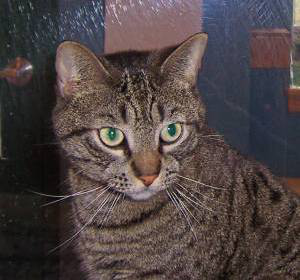

In [2]:
img

## Using `IPython.display.display()` for Rendering `PIL` Images

Though the previous way of rendering images is nice, it's not terribly convenient. For instance, what if we have two images that we want to display as the result of executing a single jupyter cell?

Thankfully, jupyter provides a more flexible way of displaying a PIL image. Simply pass a PIL object to the `IPython.display.display()` function and `jupyter` will display it exactly the same as before.

### Tasks

- Use `IPython.display.display()` to display the cat image

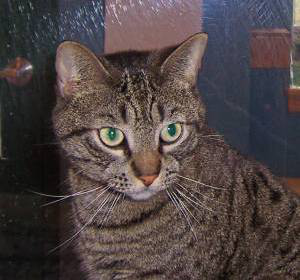

In [3]:
from IPython.display import display

display(img)

### Tranforming Images with `PIL`

Now that we know how to load and display images, you might be wondering how we can transform an image. Indeed, `PIL` provides several convenience functions for exactly this. Let's get some practice doing so now.

### Tasks

- Rotate the image by `45` degrees and display it
- Resize the image to `(128,128)` and display it
- Flip the image horizontally and display it
- Flip the image vertically and display it

### Hints

- Look at the `PIL.Image.rotate(), PIL.Image.resize(),` and `PIL.Image.transpose()` functions

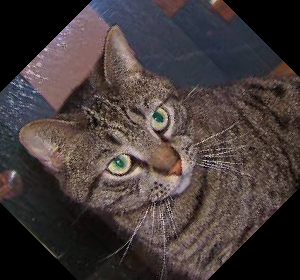

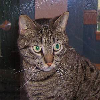

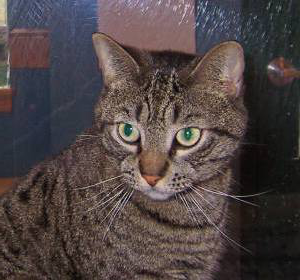

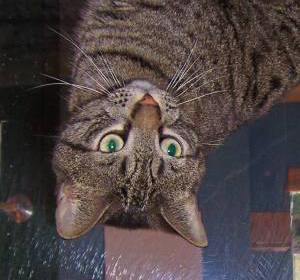

In [4]:
import PIL

display(img.rotate(45))
display(img.resize(size=[100, 100]))
display(img.transpose(method=PIL.Image.FLIP_LEFT_RIGHT))
display(img.transpose(method=PIL.Image.FLIP_TOP_BOTTOM))

# Images as Data

Although PIL provides a convenient way to load and transform image data, it is not exactly clear how this is done based on the examples so far. If we wish to build deep learning systems that operate on images, we need to know a little bit more about how PIL works - namely how PIL represents images.

## Pixels

Conceptually, an image can be thought of as a matrix of *pixels*, where a pixel is an integer ranging from `0-255`. If we interpret `0` as the color black, `255` as the color white, and each value in between as a grayish interpolation between white and black, we have the *grayscale* representation.

While simple, this representation cannot encode colors. Since we want to work with colored images, we need to incorporate a *color model*. The simplest and most well-known color model is the *RGB* color model, which we will now discuss briefly.

## The `RGB` Color Model

The RGB color model is an additive color model in which red, green and blue light are added together in various ways to reproduce a broad array of colors. Instead of having a single matrix of grayscale pixel intensities, an RGB color model consists of *three* pixel matrices, where a pixel's intensity encodes how red, green, or blue it is depending on which matrix it resides in.

![RGB Monkey](images/RGB.png)

Given this understanding, a natural encoding of an image is a `numpy` array with shape `(3, height, width)`. Let's convert a `PIL.Image` to a `numpy` array and see if this is the form our cat image takes.

In [5]:
import numpy as np

x = np.array(img)
x.shape

(280, 300, 3)

As can be seen, PIL represents an RGB image as an array shape `(width, height, 3)`. Sadly this representation will make it very difficult to perform transformations on images.

Luckily keras provides helper functions for converting to and from PIL images and numpy arrays with our desired shape.

In [7]:
from keras.preprocessing.image import img_to_array, array_to_img

x = img_to_array(img)
x.shape

(3, 280, 300)

As a note, we have to specify `dim_ordering=th` for theano dimension ordering when converting between PIL and numpy. This is because tensorflow uses yet another representation for images of shape `(height, width, 3)`. Converting between different representations is non-trivial and I recommend to sticking with the keras helper functions at all times.

Keras also provides the helper function `keras.preprocessing.image.array_to_img()` to convert from numpy arrays to PIL images.

---

# Preprocessing Images

Now that we can convert PIL images to numpy arrays, let's practice manipulating images with numpy.

## Feature Scaling

In machine learning, [feature scaling](https://en.wikipedia.org/wiki/Feature_scaling) often makes or breaks the performance of a model and image data is no exception to this rule. Normally we would zero-center each color channel of our data using the sample mean. However, since we only have one image, let's use the mean RGB value as computed on the ImageNet dataset to zero-center our cat image.

### Tasks

- Use the mean RGB value from ImageNet to zero-center our cat image

### Hints

- Use [broadcasting](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html)

In [8]:
import numpy as np

mean_blue, mean_green, mean_red = 103.939, 116.779, 123.68

mu = np.array([mean_red, mean_blue, mean_green])
mu = np.expand_dims(mu, axis=1)
mu = np.expand_dims(mu, axis=1)

np.mean(x - mu, axis=0)

array([[-73.79933333, -73.79933333, -72.466     , ...,  79.20066667,
         73.534     ,  72.20066667],
       [-72.79933333, -72.79933333, -72.466     , ...,  75.86733333,
         70.534     ,  68.20066667],
       [-72.79933333, -72.79933333, -72.466     , ...,  71.86733333,
         70.20066667,  69.534     ],
       ..., 
       [-83.79933333, -85.79933333, -89.79933333, ..., -89.466     ,
        -82.466     , -67.13266667],
       [-83.79933333, -85.79933333, -89.79933333, ..., -84.13266667,
        -80.13266667, -69.466     ],
       [-83.79933333, -86.79933333, -90.79933333, ..., -75.13266667,
        -82.13266667, -84.466     ]])

# Convolutions

We now move to one of the most important operations on images - *convolution*.

## Example

Let's start with an example of 2D-convolution *in action* to build intuition.

![2D Convolution](https://i.stack.imgur.com/I7DBr.gif3)

To perform a convolution, we need an *image* $I$ and a convolutional *filter* $F$. In the above example, we have
$
I = \begin{bmatrix}
1 & 1 & 1 & 0 & 0 \\
0 & 1 & 1 & 1 & 0 \\
0 & 0 & 1 & 1 & 1 \\
0 & 0 & 1 & 1 & 0 \\
0 & 1 & 1 & 0 & 0
\end{bmatrix}
$
and
$
F = \begin{bmatrix}
1 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 1
\end{bmatrix}
$. The output of a 2D convolution is a 2D matrix of *activations* $A$, often referred to as a *feature map*.
We say we *convolve* $F$ with $I$ (denoted $F \star I$) by *sliding* $F$ across $I$ and, at each step, taking a two-dimensional dot-product between $F$ and $I$, and recording the resulting scalar in the corresponding location in $A$. Formally, we define convolution as

$$
(I \star F)[x, y] = \sum_{i = -k}^k \sum_{j = -k}^k I[x+i, y+j] * F[i, j]
$$

where $k = \lfloor \frac{f}{2} \rfloor$ where $f$ is the length of the $F$. Here we assume that the $f$ is odd.

## Convolution As a Noise Reducer

One use of convolution with images is in reducing the *noise* present in an image. By noise, we mean local patches in the image with large gradients (i.e. differences in pixel intensity value). Such large gradients can be caused by lighting, for example.

By using a uniform convolutional filter, the corresponding activation map will be a *smoothed* version of the original image. This is because every activation in the activation map corresponds to the unweighted average of a small patch of pixels. By computing an average in this manner, we reduce the noise present in an image, which has a *blurring* effect.

For the following set of experiments, we take only the red channel of our cat image because `scipy.signal.correlate2d()` requires a 2D matrix.

In [9]:
from scipy import signal
import seaborn as sns
import pandas as pd
cm = sns.light_palette('red', as_cmap=True)

filter_size = 5
w = np.ones([filter_size, filter_size], dtype=np.float) * (1/filter_size**2)

pd.DataFrame(w).style.background_gradient(cmap=cm).set_caption('Blurring Filter')

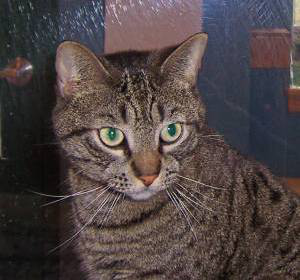

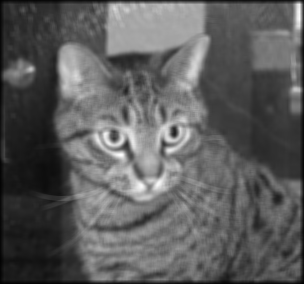

In [10]:
a = signal.correlate2d(x[0], w)
display(img)
img_blurred = array_to_img(np.expand_dims(a, axis=0))
display(img_blurred)

## Convolution as an Image Sharpener

In the same way we blur an image by taking an unweighted average of every pixel's neighborhood, we can *weighted averaging* to *sharpen*, or enhance an image. The idea is that by placing a higher weight on the center pixel in a patch and adding negative weight to surrounding pixels, we will *accentuate* differences.

In order to make the sharpening effect more striking, we use the previous blurred cat image as the input to our sharpener.

In [11]:
ww = np.zeros([filter_size, filter_size], dtype=np.float)
ww[filter_size//2, filter_size//2] = 2

pd.DataFrame(ww - w).style.background_gradient(cmap=cm).set_caption('Sharpening Filter')

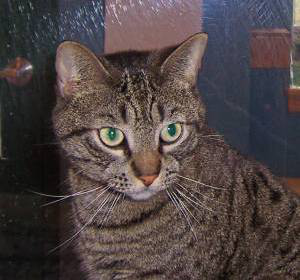

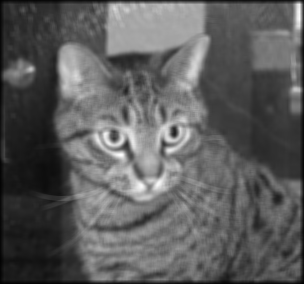

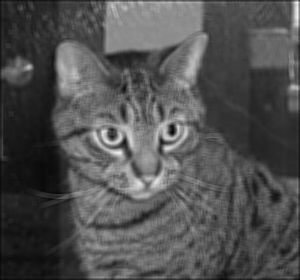

In [12]:
aa = signal.correlate2d(a, ww-w, mode='valid')
display(img)
display(img_blurred)
img_sharpened = array_to_img(np.expand_dims(aa, axis=0))
img_sharpened

## Convolution as an Edge Detector

*Edges* in a images are places of rapid change in pixel intensity. It follows that edges should appear where the derivative is high.

Since images consist of discrete pixels, we settle for an approximation of the derivative. In the simplest case, we simply subtract the intensity of neighboring horizontal pixels to approximate $\frac{\partial I(x, y)}{\partial x}$ and subtract the intensity of neighboring vertical pixels to approximate $\frac{\partial I(x, y)}{\partial y}$.

You might be able to see that we can implement the operating of subtracting neighboring pixels from one another with convolution and appropriate choice of filter.

### Tasks

- What convolutional filter corresponds to $\frac{\partial I(x, y)}{\partial x}$? What about its mirror image?
- What convolutional filter corresponds to $\frac{\partial I(x, y)}{\partial y}$? What about its mirror image?

In [13]:
w = np.array([[-1, 0, 1]], dtype=np.float)
pd.DataFrame(w).style.background_gradient(cmap=cm).set_caption(r'$\frac{\partial I(x, y)}{\partial x}$')

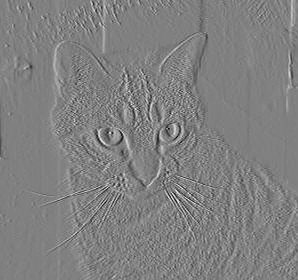

In [14]:
a = signal.correlate2d(x[0], w, mode='valid')
array_to_img(np.expand_dims(a, axis=0))

In [15]:
w = np.array([[ 1],
              [ 0],
              [-1]], dtype=np.float)

pd.DataFrame(w).style.background_gradient(cmap=cm).set_caption(r'$\frac{\partial I(x, y)}{\partial y}$')

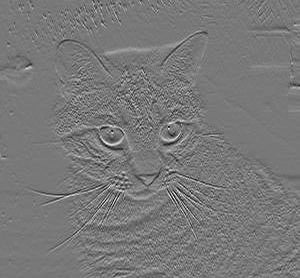

In [16]:
a = signal.correlate2d(x[0], w, mode='valid')
array_to_img(np.expand_dims(a, axis=0))

## Convolution as a Template Matching

Finally, we can think of convolutional filters as *templates*, which produce strong activations on patches of the image which reflect the *pattern* the filter is "optimized" to detect. In the last section, we could think of gradient filters as templates for edges, though in this section we will consider a template to be matching a *higher-level* pattern.

For example, consider the following template.

In [17]:
top = 120
left, right = 90, 190
bottom = 150

img_eyes = img.crop([left, top, right, bottom])
display(img_eyes)

This template is a valid convolutional filter which we can convolve over the original image.

### Tasks

- Which part of the activation map will have the strongest activation? Why?

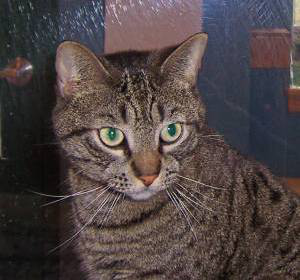

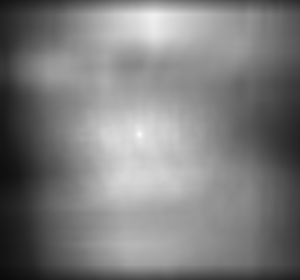

In [18]:
w_eyes = img_to_array(img_eyes)
a = signal.correlate2d(x[0], w_eyes[0], mode='same')
display(img)
display(img_eyes)
array_to_img(np.expand_dims(a, axis=0))

We see the strongest activation in the middle of the image where the filter overlaps with the cat's eyes. We also see fairly strong activations against the background. This suggests that naive template matching may be insufficient for detecting high-level features in realistic images.